# 🚀 Part 4: To Infinity and Beyond!
Let's re-read the data again and re-initialise the weights.

In [14]:
# Import relevant libraries
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np
from helper import helper

random.seed(2021) # We set a seed to ensure our samples will be the same every time we run the code.

In [15]:
# First define the function without running it
def load_data_fashion_mnist(batch_size, n_workers):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

# Then execute the function here
batch_size = 1024  # Set to 256 on your own device
n_workers = 0      # Set to 4 on your own device
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, n_workers = n_workers)

In [16]:
# Initialise LeNet Architecture (ans)
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), 
                    nn.Linear(84, 10))

In [17]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # We will only set the weights from linear and Conv2d layers, since pooling layers do not require this
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights) # nb: this takes in a function as an argument

lr = 0.9 
optimizer = torch.optim.SGD(net.parameters(), lr=lr) 
loss = nn.CrossEntropyLoss() 

## Scaling for Training
The number of **epochs** is the number of times our model runs over the entire data set once. 
* Too few epochs and the model does not get a chance to capture the patterns in the data.
* Too many epochs and the model overfits and will not generalise well (we shall see an example later).

#### For mybinder users
It is recommended that you use no more than `7` epochs (otherwise it will take far too long to run).

#### For those on their own machines
It is recomended that you run over around `10` epochs. Feel free to experiment with this number.

**Warning:** The code below will take around 10 minutes to run (depending on the number of epochs). Feel free to grab a coffee while you wait.

![](../images/train_time.png)

([source](https://www.reddit.com/r/ProgrammerHumor/comments/9cu51a/shamelessly_stolen_from_xkcd_credit_where_is_due/))

In [12]:
timer = helper.Timer() 
num_epochs = 7

# Keep track of accuracy for each epoch
train_accuracy = np.array([])
test_accuracy = np.array([])
epochs = np.arange(num_epochs) + 1

for epoch in range(num_epochs):
    metric = helper.Accumulator(3) # define a 3d accumulator
    net.train() # set to train
    for i, (X, y) in enumerate(train_iter): # Loop thru each mini-batch
        timer.start()
        optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
        y_hat = net(X) # Forward pass on the data to make prediction
        l = loss(y_hat, y) # calculate the loss 
        l.backward() # back propagate the loss
        optimizer.step() # step forward in optimisation
        with torch.no_grad():
            metric.add(l * X.shape[0], helper.accuracy(y_hat, y), X.shape[0]) # mini-batch loss,  # matches, # total examples
        timer.stop()
        train_l = metric[0] / metric[2] # loss per unit 
        train_acc = metric[1] / metric[2] # training accuracy
    test_acc = helper.evaluate_accuracy(net, test_iter)
    
    train_accuracy = np.append(train_accuracy, train_acc)
    test_accuracy = np.append(test_accuracy, test_acc)

print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
      f'test acc {test_acc:.3f}')
print(f'{timer.sum():.1f} sec taken ')

loss 0.902, train acc 0.643, test acc 0.623
34.8 sec taken 


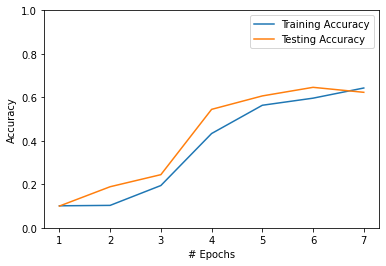

In [13]:
# Let's plot it
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, test_accuracy, label = "Testing Accuracy")
plt.ylim(0, 1)
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

How did that compare with our previous model? How does that compare with random assignment?

## Overfitting
![overfit](../images/overfit.png)

# 📓 Appendix

## 